# VQE Performance Under Quantum Noise
Extending $H_{2}$ / $H_{3}^+$ simulations to realistic quantum conditions

## 1. Import statements

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 2. Define $H_{2}$

In [2]:
def setup_h2_system():
    symbols = ["H", "H"]
    coordinates = np.array([[-0.673, 0, 0], [0.673, 0, 0]])
    
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates)
    hf = qchem.hf_state(electrons=2, orbitals=qubits)
    
    print(f"H2 molecule setup:")
    print(f"  Qubits: {qubits}")
    print(f"  HF state: {hf}")
    
    return H, qubits, hf

## 3. VQE without noise (base example)

In [3]:
def run_perfect_vqe(H, qubits, hf):
    
    # Perfect device
    dev = qml.device("default.qubit", wires=qubits)
    
    # Same ansatz
    def ansatz(params):
        qml.BasisState(np.array(hf), range(qubits))
        qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    
    @qml.qnode(dev)
    def cost_function(params):
        ansatz(params)
        return qml.expval(H)
    
    # Same optimization
    opt = qml.GradientDescentOptimizer(stepsize=0.4)
    params = np.array([0.0])
    
    energies = []
    for step in range(20):
        params, energy = opt.step_and_cost(cost_function, params)
        energies.append(energy)
    
    final_energy = energies[-1]
    print(f"Perfect VQE energy: {final_energy:.8f} Ha")
    
    return final_energy, energies


## 4. Noisy VQE using finite shots

In [4]:
def run_noisy_vqe(H, qubits, hf, shots=100):
    
    # Noisy device (finite shots)
    dev = qml.device("default.qubit", wires=qubits, shots=shots)
    
    # Same ansatz
    def ansatz(params):
        qml.BasisState(np.array(hf), range(qubits))
        qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    
    @qml.qnode(dev)
    def noisy_cost_function(params):
        ansatz(params)
        return qml.expval(H)
    
    # Same optimization (but noisier gradients)
    opt = qml.GradientDescentOptimizer(stepsize=0.3)  # Smaller steps for noisy gradients
    params = np.array([0.0])
    
    energies = []
    for step in range(20):
        params, energy = opt.step_and_cost(noisy_cost_function, params)
        energies.append(energy)
    
    final_energy = energies[-1]
    print(f"Noisy VQE energy: {final_energy:.8f} Ha")
    
    return final_energy, energies

## 5. Compare different noise levels

In [5]:
def compare_noise_levels():

    print("--------NOISE LEVEL COMPARISON--------")

    
    # Setup system
    H, qubits, hf = setup_h2_system()
    
    # Get perfect baseline
    perfect_energy, perfect_history = run_perfect_vqe(H, qubits, hf)
    
    # Test different shot counts (more shots = less noise)
    shot_counts = [50, 100, 500, 1000, 5000]
    results = []
    
    print(f"\nTesting different noise levels:")
    print("Shots | Energy (Ha)   | Error (mHa) | Noise Level")
    print("-" * 50)
    
    for shots in shot_counts:
        noisy_energy, _ = run_noisy_vqe(H, qubits, hf, shots)
        error = abs(noisy_energy - perfect_energy) * 1000  # mHa
        noise_level = "High" if shots < 200 else "Medium" if shots < 1000 else "Low"
        
        results.append({
            'shots': shots,
            'energy': noisy_energy,
            'error': error
        })
        
        print(f"{shots:5d} | {noisy_energy:11.6f} | {error:8.2f}  | {noise_level}")
    
    return perfect_energy, perfect_history, results

## 6. Visualization

\* *AI was used for the visualization code*

In [6]:
def plot_noise_comparison(perfect_energy, perfect_history, noise_results):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Energy error vs shot count
    shots = [r['shots'] for r in noise_results]
    errors = [r['error'] for r in noise_results]
    
    ax1.plot(shots, errors, 'ro-', linewidth=2, markersize=8)
    ax1.axhline(y=1.0, color='green', linestyle='--', label='Chemical Accuracy (1 mHa)', linewidth=2)
    ax1.set_xlabel('Number of Shots')
    ax1.set_ylabel('Energy Error (mHartree)')
    ax1.set_title('VQE Accuracy vs Quantum Noise')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Perfect vs noisy convergence
    steps = range(len(perfect_history))
    
    # Get one noisy example for comparison
    _, noisy_history = run_noisy_vqe(*setup_h2_system(), shots=100)
    
    ax2.plot(steps, perfect_history, 'b-', label='Perfect VQE', linewidth=2)
    ax2.plot(range(len(noisy_history)), noisy_history, 'r-', label='Noisy VQE (100 shots)', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Optimization Step')
    ax2.set_ylabel('Energy (Hartree)')
    ax2.set_title('Perfect vs Noisy Optimization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Main analysis

--------NOISE LEVEL COMPARISON--------
H2 molecule setup:
  Qubits: 4
  HF state: [1 1 0 0]
Perfect VQE energy: -1.13684958 Ha

Testing different noise levels:
Shots | Energy (Ha)   | Error (mHa) | Noise Level
--------------------------------------------------
Noisy VQE energy: -1.15883060 Ha
   50 |   -1.158831 |    21.98  | High
Noisy VQE energy: -1.15344042 Ha
  100 |   -1.153440 |    16.59  | High
Noisy VQE energy: -1.12872989 Ha
  500 |   -1.128730 |     8.12  | Medium
Noisy VQE energy: -1.12614191 Ha
 1000 |   -1.126142 |    10.71  | Low
Noisy VQE energy: -1.13994064 Ha
 5000 |   -1.139941 |     3.09  | Low
H2 molecule setup:
  Qubits: 4
  HF state: [1 1 0 0]
Noisy VQE energy: -1.13514835 Ha


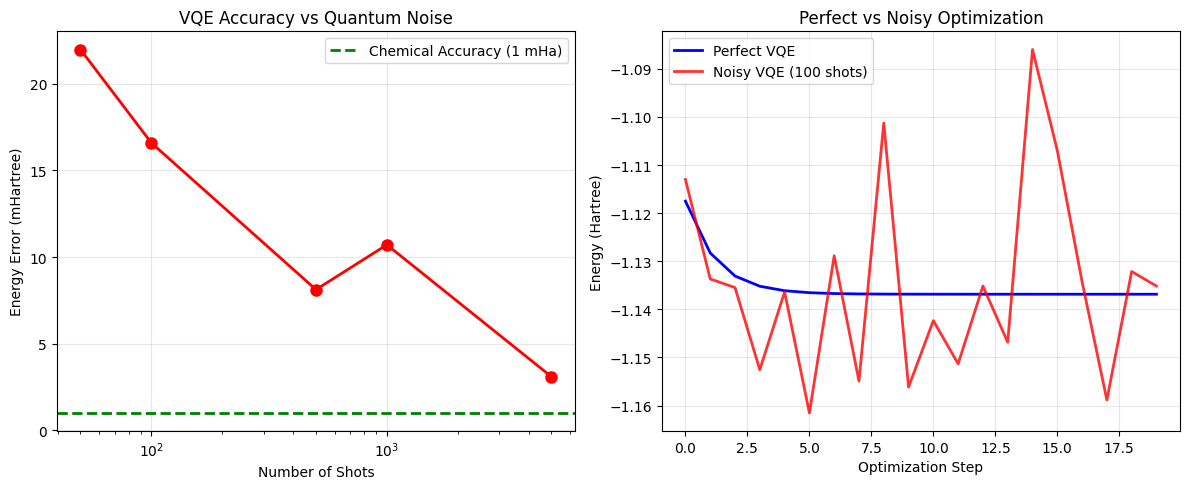

Results:
Perfect VQE energy: -1.13684958 Ha
Worst noise error: 21.98 mHa
Best noise error: 3.09 mHa
   • Need more than 5000 shots for chemical accuracy


In [7]:
def main():
    
    # Compare noise levels
    perfect_energy, perfect_history, noise_results = compare_noise_levels()
    
    # Create plots
    plot_noise_comparison(perfect_energy, perfect_history, noise_results)
    
    # Find when we achieve chemical accuracy
    chemical_accuracy_shots = None
    for result in sorted(noise_results, key=lambda x: x['shots']):
        if result['error'] < 1.0:  # 1 mHa = chemical accuracy
            chemical_accuracy_shots = result['shots']
            break
    
    print(f"Results:")
    print(f"Perfect VQE energy: {perfect_energy:.8f} Ha")
    print(f"Worst noise error: {max(r['error'] for r in noise_results):.2f} mHa")
    print(f"Best noise error: {min(r['error'] for r in noise_results):.2f} mHa")
    
    if chemical_accuracy_shots:
        print(f"   • Chemical accuracy achieved with {chemical_accuracy_shots} shots")
    else:
        print(f"   • Need more than 5000 shots for chemical accuracy")
    

if __name__ == "__main__":
    main()